In [1]:
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import pyro
import torch
import VAE
import ConvEncoderDecoder as CED
import LinearEncoderDecoder as LED

from pyro.contrib.examples.util import MNIST
import torchvision.transforms as transforms
import torchvision.datasets as dset

In [2]:
def setup_data_loaders(batch_size=128, use_cuda=False):
    root = './data'
    download = True
    trans = transforms.ToTensor()
    train_set = MNIST(root=root, train=True, transform=trans,
                      download=download)
    test_set = MNIST(root=root, train=False, transform=trans)

    kwargs = {'num_workers': 1, 'pin_memory': use_cuda}
    train_loader = torch.utils.data.DataLoader(dataset=train_set,
        batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(dataset=test_set,
        batch_size=batch_size, shuffle=False, **kwargs)
    return train_loader, test_loader

In [3]:
def train(svi, train_loader, use_cuda=False):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for x, _ in train_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # do ELBO gradient and accumulate loss
        epoch_loss += svi.step(x)

    # return epoch loss
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train

In [4]:
def evaluate(svi, test_loader, use_cuda=False):
    # initialize loss accumulator
    test_loss = 0.
    # compute the loss over the entire test set
    for x, _ in test_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # compute ELBO estimate and accumulate loss
        test_loss += svi.evaluate_loss(x)
    normalizer_test = len(test_loader.dataset)
    total_epoch_loss_test = test_loss / normalizer_test
    return total_epoch_loss_test

In [6]:
USE_CUDA = False
NUM_EPOCHS = 20
TEST_FREQUENCY = 5
train_loader, test_loader = setup_data_loaders(batch_size=256, use_cuda=USE_CUDA)

# clear param store
pyro.clear_param_store()

model = VAE.VAE(LED.LinearEncoder(2, 400, 100), LED.LinearDecoder(2, 400, 100))
#model = VAE.VAE(CED.ConvEncoder(2, 400), CED.ConvDecoder(2, 400))

optimizer = Adam({"lr": 1.0e-3})
svi = SVI(model.model, model.guide, optimizer, loss=Trace_ELBO())

train_elbo = []
test_elbo = []
# training loop
for epoch in range(NUM_EPOCHS):
    total_epoch_loss_train = train(svi, train_loader, use_cuda=USE_CUDA)
    train_elbo.append(-total_epoch_loss_train)
    print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))

    if epoch % TEST_FREQUENCY == 0:
        # report test diagnostics
        total_epoch_loss_test = evaluate(svi, test_loader, use_cuda=USE_CUDA)
        test_elbo.append(-total_epoch_loss_test)
        print("[epoch %03d] average test loss: %.4f" % (epoch, total_epoch_loss_test))

[epoch 000]  average training loss: 203.8435
[epoch 000] average test loss: 174.3890
[epoch 001]  average training loss: 169.2816
[epoch 002]  average training loss: 163.4734
[epoch 003]  average training loss: 159.8700
[epoch 004]  average training loss: 156.9741
[epoch 005]  average training loss: 154.7339
[epoch 005] average test loss: 154.4602
[epoch 006]  average training loss: 152.8922
[epoch 007]  average training loss: 151.1480
[epoch 008]  average training loss: 149.7984
[epoch 009]  average training loss: 148.5945
[epoch 010]  average training loss: 147.6509
[epoch 010] average test loss: 148.3640
[epoch 011]  average training loss: 146.8186
[epoch 012]  average training loss: 146.1433
[epoch 013]  average training loss: 145.4916
[epoch 014]  average training loss: 144.9938
[epoch 015]  average training loss: 144.5810
[epoch 015] average test loss: 146.2313
[epoch 016]  average training loss: 144.0313
[epoch 017]  average training loss: 143.5667
[epoch 018]  average training 

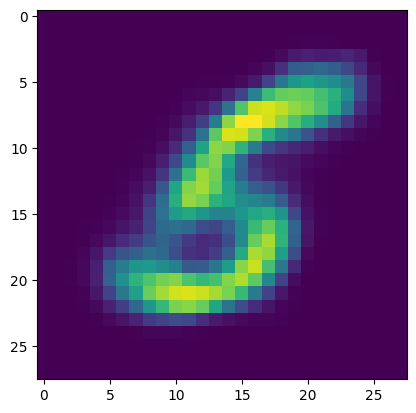

In [36]:
import numpy as np
s = model.decoder(torch.randn(1, 2)).detach().numpy().reshape(28, 28)
import matplotlib.pyplot as plt

plt.imshow(s)
plt.show()


In [5]:
USE_CUDA = False
NUM_EPOCHS = 20
TEST_FREQUENCY = 5
train_loader, test_loader = setup_data_loaders(batch_size=256, use_cuda=USE_CUDA)

# clear param store
pyro.clear_param_store()

model2 = VAE.VAE(CED.ConvEncoder(2, 400), CED.ConvDecoder(2, 400))

optimizer2 = Adam({"lr": 1.0e-3})
svi2 = SVI(model2.model, model2.guide, optimizer2, loss=Trace_ELBO())

train_elbo = []
test_elbo = []
# training loop
for epoch in range(NUM_EPOCHS):
    total_epoch_loss_train = train(svi2, train_loader, use_cuda=USE_CUDA)
    train_elbo.append(-total_epoch_loss_train)
    print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))

    if epoch % TEST_FREQUENCY == 0:
        # report test diagnostics
        total_epoch_loss_test = evaluate(svi2, test_loader, use_cuda=USE_CUDA)
        test_elbo.append(-total_epoch_loss_test)
        print("[epoch %03d] average test loss: %.4f" % (epoch, total_epoch_loss_test))

[epoch 000]  average training loss: 237.8967


NameError: name 'svi' is not defined

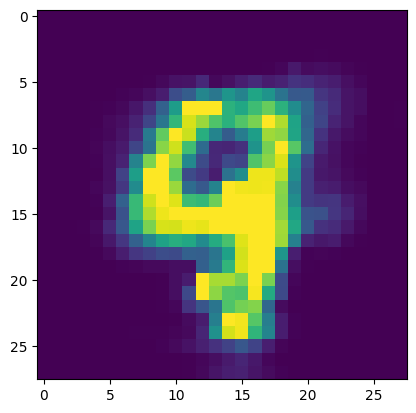

In [64]:
s = model2.decoder(torch.randn(1, 2)).detach().numpy().reshape(28, 28)

plt.imshow(s)
plt.show()

In [65]:
USE_CUDA = False
NUM_EPOCHS = 20
TEST_FREQUENCY = 5
train_loader, test_loader = setup_data_loaders(batch_size=256, use_cuda=USE_CUDA)

# clear param store
pyro.clear_param_store()

model3 = VAE.VAE(CED.ConvEncoder(2, 400), LED.LinearDecoder(2, 400, 100))
#model = VAE.VAE(CED.ConvEncoder(2, 400), CED.ConvDecoder(2, 400))

optimizer = Adam({"lr": 1.0e-3})
svi = SVI(model3.model, model3.guide, optimizer, loss=Trace_ELBO())

train_elbo = []
test_elbo = []
# training loop
for epoch in range(NUM_EPOCHS):
    total_epoch_loss_train = train(svi, train_loader, use_cuda=USE_CUDA)
    train_elbo.append(-total_epoch_loss_train)
    print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))

    if epoch % TEST_FREQUENCY == 0:
        # report test diagnostics
        total_epoch_loss_test = evaluate(svi, test_loader, use_cuda=USE_CUDA)
        test_elbo.append(-total_epoch_loss_test)
        print("[epoch %03d] average test loss: %.4f" % (epoch, total_epoch_loss_test))

[epoch 000]  average training loss: 213.5364
[epoch 000] average test loss: 190.0308
[epoch 001]  average training loss: 188.3079
[epoch 002]  average training loss: 184.8558
[epoch 003]  average training loss: 174.4955
[epoch 004]  average training loss: 170.8730
[epoch 005]  average training loss: 168.6801
[epoch 005] average test loss: 167.6675
[epoch 006]  average training loss: 166.2453
[epoch 007]  average training loss: 164.1337
[epoch 008]  average training loss: 161.5362
[epoch 009]  average training loss: 159.5850
[epoch 010]  average training loss: 158.0388
[epoch 010] average test loss: 157.6370
[epoch 011]  average training loss: 156.6311
[epoch 012]  average training loss: 155.6400
[epoch 013]  average training loss: 154.7107
[epoch 014]  average training loss: 154.0108
[epoch 015]  average training loss: 153.3893
[epoch 015] average test loss: 153.3905
[epoch 016]  average training loss: 152.8223
[epoch 017]  average training loss: 152.2392
[epoch 018]  average training 

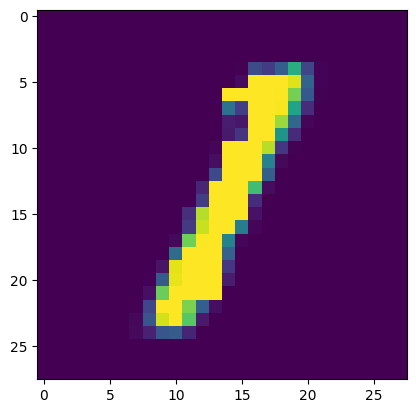

In [88]:
s = model2.decoder(torch.randn(1, 2)).detach().numpy().reshape(28, 28)

plt.imshow(s)
plt.show()